# A Manual for the Sub-Host Models of VISHN

VISHN comes equipped with 3 built-in sub-host models of viral dynamics that can be applied in a wide variety of applications as well as support for custom user-defined models. Here, we will describe the 3 bult-in models, how and when to use each one, and also provide guidance on how to implement [a custom sub-host model](https://www.medrxiv.org/content/10.1101/2022.04.22.22274137v1.full) to be compatible with VISHN. 

#### Contents:

- [Section 1](#1): The Built-In Models
    - [1.1)](#1.1) The TIVE Model
    - [1.2)](#1.2) The TIVE Lite Model
    - [1.3)](#1.3) The TIV Model
- [Section 2](#2): Guide for Writing Custom Models
    - [2.1)](#2.1) The SubHostModel Class
    - [2.2)](#2.2) A look at the implementation of the TIV model
    - [2.3)](#2.3) Implementing the Carruthers et al. Model


In [51]:
%matplotlib inline
import sys
sys.path.append('../')
import vishn as vn
# Other packages that will be used in this demo, in general not necessary to use Vishn
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
plt.style.use('seaborn-v0_8')

For this guide, we will demonstarte all of the models on a graph with only one node. Since the .edgelist format required in VISHN does not work without any edges, we will create a graph with 2 nodes connected by a single edge with weight 0, so the edge effectively does not exist and we have 2 disjoint nodes. We will seed one of these nodes with infection to visualize the data generated by each of the different sub-host models using the function defined below:

In [8]:
def plot_node(result, title, alpha=1,xlim=100, size=(7,6)):
    color = ["#1E88E5","#D81B60","#FFC107", 
             "#004D40", "#E86239", "#11C6BB"]
    # get the data for the infected node to show viral dynamics of system
    node0 = result.loc[result["node_id"]==0,:]
    plt.figure(figsize=size)
    num_compartments = len(node0.columns) - 5
    for compartment in range(1,num_compartments+1):
        plt.subplot(num_compartments, 1, compartment)
        plt.plot(node0["time"], node0.iloc[:,compartment+1],
                 color=color[compartment-1],
                 alpha=alpha)
        plt.ylabel(node0.columns[compartment+1])
        ax =  plt.gca()
        ax.set_xlim([0, xlim])
    fig = plt.gcf()
    fig.suptitle(title, fontsize=18, y=0.92)
    plt.show()

For brevity, all configuration files for the following demos have already been written.

<a id=1></a>
# Section 1: The Built-In Models of VISHN
<a id=1.1></a>
## 1.1) The TIVE Model
The TIVE model is the system of equations VISHN was originally designed around and is the most flexible of all the built-in systems. Waning immunity, multiple infection cycles, and viral load dependent transmission are all captured by the TIVE model. In the TIVE model, cells susceptible to infection (T), cells which have been infected with virus (I), viral load (V) and the immune response (E) are modeled through a system of coupled, non-linear, non-continuous first order differential equations:

$$
\begin{align}
\dot{T} &= \alpha T(1 - \frac{T + I}{N}) - 1_{V \geq V_{min}}(\beta VT), \\
\dot{I} &= 1_{V \geq V_{min}}(\beta VT - \delta I - d_X EI), \\
\dot{V} &=  1_{V \geq V_{min}}(pI - cEV) + 1_{exp}(V_{exp}), \\
\dot{E} &= rI - dE. \\
\end{align}
$$

To use the TIVE system in VISHN, the user must specify the following parameters:
- $\alpha$ (target cell regeneration rate)
- $N$ (maximum target cell population)
- $\beta$ (cell infectivity rate)
- $\delta$ (infective cell death rate)
- $d_{X}$ (infective cell clearance rate)
- $p$ (viral load growth rate)
- $c$ (viral load clearance rate)
- $r$ (immune cell growth rate)
- $d$ (immune cell clearance rate)
  
The indicator variable $1_{V\geq V_{min}}$ delineates multiple infection cycles and $1_{exp}$ activates when a host is exposed to $V_{exp}$ virus. The use of indicator varibles is a major drawback of the TIVE model since it makes deriving analytical results very difficult.

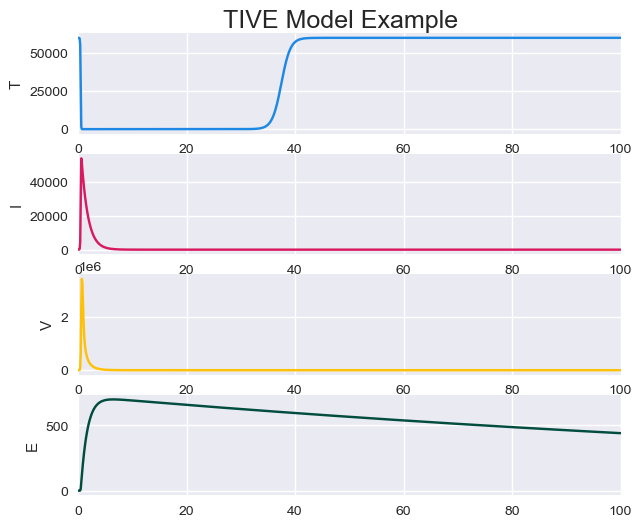

In [14]:
tive_result = vn.simulate("config_files/tive_demo.txt")
plot_node(tive_result, title="TIVE Model Example")

<a id=1.2></a>
## 1.2) The TIVE Lite Model

The TIVE Lite Model is a stripped down version of the TIVE Model that is only capable of modelling a single infection cycle. However, immunity dynamics and viral load depenedent transmission are still modeled in this system. The TIVE Lite Model is an ideal choice when reinfection is not a concern (at least for the duration of a simulation), but vaccines/other treatments may give some hosts immunity.

$$
\begin{align}
\dot{T} &= - \beta VT, \\
\dot{I} &= \beta VT - \delta I - d_X EI, \\
\dot{V} &= pI - cEV + 1_{exp}(V_{exp}), \\
\dot{E} &= rI - dE. \\
\end{align}
$$

To use the TIVE Lite system in VISHN, the user must specify the following parameters:
- $\beta$ (cell infectivity rate)
- $\delta$ (infective cell death rate)
- $d_{X}$ (infective cell clearance rate)
- $p$ (viral load growth rate)
- $c$ (viral load clearance rate)
- $r$ (immune cell growth rate)
- $d$ (immune cell clearance rate)

Compared to the full TIVE system, TIVE Lite does not have target cell regrowth or the indicator $1_{V\geq V_{min}}$ to delineate multiple infection cycles, hence why it only captures a single infection cycle

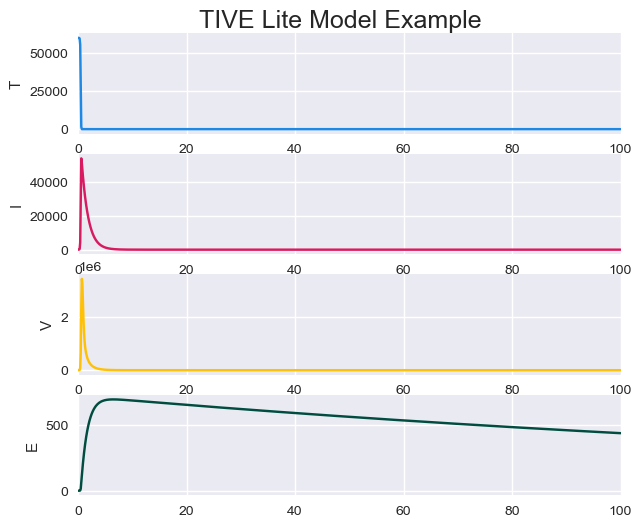

In [21]:
tive_lite_result = vn.simulate("config_files/tive_lite_demo.txt")
plot_node(tive_lite_result, title="TIVE Lite Model Example")

As seen above, the target cells never regrow after an infection, preventing any secondary infection cycles.

<a id=1.3></a>
## 1.2) The TIV Model

The TIV Model is the simplest sub-host model built into VISHN. The TIV further strips down the TIVE Model and does not model immunity dynamics or multiple infection cycles, but still captures viral load dependent transmission. Since the he TIV model is simpler, it is ideal for larger scale simulations or simulations where only viral load dependent transmission is of interest. 

$$
\begin{align}
\dot{T} &= - \beta VT, \\
\dot{I} &= \beta VT - \delta I, \\
\dot{V} &= pI - cV + 1_{exp}(V_{exp}), \\
\end{align}
$$

To use the TIV system in VISHN, the user must specify the following parameters:
- $\beta$ (cell infectivity rate)
- $\delta$ (infective cell death rate)
- $p$ (viral load growth rate)
- $c$ (viral load clearance rate)

The TIV Model has the fewest parameters, which can be advantageous for simulations that only require a simple sub-host model.

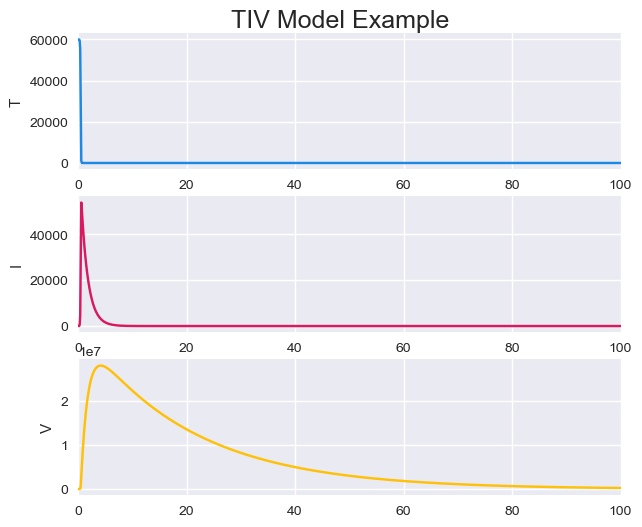

In [28]:
tiv_result = vn.simulate("config_files/tiv_demo.txt")
plot_node(tiv_result, title="TIV Model Example")

As can be seen above, the TIV model further simplifies the TIVE Lite model by removing any modelling of immunity.

<a id=2></a>
# Section 2: Guide for Custom Models

When the built-in models in VISHN are insufficient for simulating a given situation, the user may also define their own sub-host models. Here, we implement a more complex sub-host model for COVID-19 [\[Jonathan Carruthers et al., 2022\]](https://www.medrxiv.org/content/10.1101/2022.04.22.22274137v1.full)<sup>1</sup> to demonstrate how to write and format a subhost model to be compatible with VISHN.

<a id=2.1></a>
## 2.1) The SubHostModel Class


In VISHN, sub-host models are objects that belong to the SubHostModel class. Below, we provided the code for the abstract class definition of SubHostModel used in VISHN and a description of all required class attributes and methods. All attributes coming from arguments in the constructor are automatically fed in by VISHN and do not need any user input. All other attributes must be defined by the user when writing their sub-host model.

Don't worry if reading the descriptions makes it seem complicated to define a custom model, in the following sections we'll provide concrete examples that demonstrate how little effort it takes in practice to use them.

### Attributes:

-  `num_nodes (int)`: The number of hosts (nodes) in the contact network of the simulation.

- `index (int)`: The index of the viral load (or other infection driving quantity) compartment, starting from 0, to be used to calculate infection probabilities.

- `compartments (int)`: The number of equations used to define the system.
e.g. the TIVE model has 4, the TIV has 3.

- `compartment_names (list)`: The label of each compartment of the sub-host model, ordered as they are in the equation function, to be used when returning the data as a dataframe.

- `min_vload (float)`: The minimum viral load required to be considered infectious.

### Methods:

- `equation`: the function defining the sub-host system of differential equations. The system must be written with arguments in the order `self`,`time`, `x`, `trigger`. Again, VISHN will automatically create and pass all arguments to this function; these descriptions are just to help understand how to use them in your own implementation.

    #### Arguments:
    - `time (float)`: The current time step in the solver
    - `x (np.array)`: The flattened initial values array fot all states and all nodes at the given time step. This is an array with shape (`num_nodes` $\times$ `compartments`, 1) holding all states of the system for all nodes. This array must be formatted such that the first "num_nodes" entries correspond to the first compartment for all nodes, the next num_nodes entries after these correspond to the second, etc.

      - e.g. for a network of 10 hosts using the TIV system, `x` would have dimension (30,1). Entries 0-9 in `x` would hold the "T" states for all nodes, entries 10-19 in `x` would hold the "I" states for all nodes and entries 20-29 in `x` would hold the "V" states for  all nodes.


    - `trigger (np.array)`: An array of shape (`num_nodes`,1) where the ith entry holds the viral load host i was infected with.
    #### Returns:
  - `dx`: The array containing all newly solved states of the system based on the initial values passed by `x`. Has `num_nodes` $\times$ `compartments` rows and the number of columns depends on the `spd` argument in the configuration file. The first `num_nodes` rows contain the data for the first compartment for all nodes, the next num_nodes rows after these correspond to the second, etc.

In [35]:
class SubHostModel(ABC):
    """
    Abstract class outlining the required format for a sub-host model to be 
    used in VISHN. 
    """
    def __init__(self, num_nodes, minVload, paramDf):
        """
        SubHostModel constructor.
        """
        self.num_nodes = num_nodes
        self.index = 0
        self.compartments = 0
        self.compartment_names = []
        self.min_vload = minVload
    @abstractmethod
    def equation(self, time, x, trigger):
        """
        the function defining the sub-host system of differential 
        equations. The system must be writtien in the format such that it can 
        be evaluated by scipy's solve_ivp. 
        
        Arguments must be in the order time, x, trigger.
        """
        pass

<a id=2.2></a>
## 2.2) A look at the implementation of the TIV Model

Here we provide the implementation of the TIV model to help clarify the descriptions above. An important detail to notice here is that we read in the parameter values from the parameter dataframe as vectors to be used in the system. This is not required, but recommended.

In [38]:
class Tiv(SubHostModel):
    def __init__(self, num_nodes, minVload, paramDf):
        """
        constructor
        """
        self.num_nodes = num_nodes
        # the "V" equation is 3rd, so it is indexed by 2
        self.index = 2
        # Has three compartments T, I, and V
        self.compartments = 3
        self.min_vload = minVload
        # these are just to help label columns when data is returned to you
        self.compartment_names =["T","I","V"]
        # reading in each parameter from the parameter dataframe as a vector
        (self.delta, self.p, self.c, self.beta) = (
            paramDf[col].values for col in ["delta", "p", "c", "beta"])
        
    def equation(self, time, x, trigger):
        """
        The system of differential equations
        """
        # separating the entries of vector "x" into its respective compartments
        t = x[0:self.num_nodes]
        i = x[self.num_nodes:2*self.num_nodes]
        v = x[2*self.num_nodes:]
        # use dx like a vector for the LHS of the equations
        dx = np.zeros(self.num_nodes*3)
        dx[0:self.num_nodes] = -self.beta*v*t
        dx[self.num_nodes:2*self.num_nodes] = self.beta*v*t - self.delta*i
        dx[2*self.num_nodes:] = self.p*i - self.c*v + trigger
        return dx


<a id=2.3></a>
## 2.3) Implementing the Carruthers et al.<sup>1</sup> Model


The Carruthers et al. model has 6 compartments: 
- Cells susceptible to infection ($T$)
- Cells in an "eclipse phase" where they are infected but not yet producing virus ($E$)
- Infected celss producing virus ($I$)
- Infectious viral load, i.e. virus that infects more cells in the body ($V_{inf}$)
- Total viral load ($V_{tot}$)
- Immune response ($C$)

The main distinction between this model and the TIVE is that it incorporates an eclipse phase for modelling the infection of cells and distinguishes infectious viral load from total viral load in the host. The model is given below:

$$
\begin{align}
\dot{T} &= -\beta TV_{inf},\\
\dot{E} &= \beta TV_{inf} - kE, \\
\dot{I} &= kE - \delta I - k_CCI, \\
\dot{V_{inf}} &= p_{inf}I - c_{inf}V_{inf}, \\
\dot{V_{tot}} &= p_{tot}I - c_{tot}V_{tot}, \\
\dot{C} &= \frac{rCV_{tot}}{V_{tot}+s} - \delta_C C. \\
\end{align}
$$

For brevity, we will ommit a full description of all parameters. For those interested in learning more about this system, the [full paper](https://www.medrxiv.org/content/10.1101/2022.04.22.22274137v1.full) is available free on medRxiv.

Below, we implement this model in VISHN:

In [43]:
# since we already defined SubHostModel, don't need to import it from equation_lib.py
class carruthers(SubHostModel):
    def __init__(self, num_nodes, minVload, paramDf):
        """
        Constructor for the carruthers equation
        """
        self.num_nodes = num_nodes
        # use V_inf to drive infections, the 4th compartment
        self.index = 3
        # has 6 compartments
        self.compartments = 6
        self.min_vload = minVload
        self.compartment_names =["T","E","I", "V_inf", "V_tot", "C"]
        # has lots of parameters to read in...
        (self.beta, self.k, self.delta, self.k_C, self.p_inf, 
         self.c_inf, self.p_tot, self.c_tot, self.r, self.s, self.delta_C) = (
            paramDf[col].values for col in ["beta", "k", "delta", "k_C", "p_inf", 
                                            "c_inf", "p_tot", "c_tot", "r", "s", "delta_C"])
        
    def equation(self, time, x, trigger):
        """
        Implements the carruthers system for VISHN compatibility
        """
        # separate x into the compartments
        t = x[0:self.num_nodes]
        e = x[self.num_nodes:2*self.num_nodes]
        i = x[2*self.num_nodes:3*self.num_nodes]
        v_inf = x[3*self.num_nodes:4*self.num_nodes]
        v_tot = x[4*self.num_nodes:5*self.num_nodes]
        c = x[5*self.num_nodes:]
        # create dx for LHS
        dx = np.zeros(self.num_nodes*6)
        # write the equation, add external trigger to the v_inf compartment
        dx[0:self.num_nodes] = -self.beta*t*v_inf
        dx[self.num_nodes:2*self.num_nodes] = self.beta*t*v_inf - self.k*e
        dx[2*self.num_nodes:3*self.num_nodes] = self.k*e - self.delta*i - self.k_C*c*i
        dx[3*self.num_nodes:4*self.num_nodes] = self.p_inf*i - self.c_inf*v_inf + trigger
        dx[4*self.num_nodes:5*self.num_nodes] = self.p_tot*i - self.c_tot*v_tot
        dx[5*self.num_nodes:] = (self.r*c*v_tot)/(v_tot + self.s) - self.delta_C*c
        return dx


To use a custom class in the configuration file, use the format module_name.class_name in the file path. When using a class defined in the same script as the call to vn.simulate(), the module name is \_\_main\_\_.

In [46]:
vn.print_config_file("config_files/carruthers.txt")

NetworkFile=network_files/carruthers_demo.edgelist
InitialHostStates=host_initialconditions/carruthers_init.csv
ParameterData=host_parameters/carruthers_params.csv

Center=50000.0
Steepness=-6e-05

InitialExposure=1e-05
MinimalViralLoad=1e-05
Equation=__main__.carruthers

Duration=100
SamplesPerDay=6
Seed=0



If we instead defined the carruthers class in a file called "example.py", the Equation parameter in the configuration file would be "example.carruthers" instead of "\_\_main\_\_.carruthers"

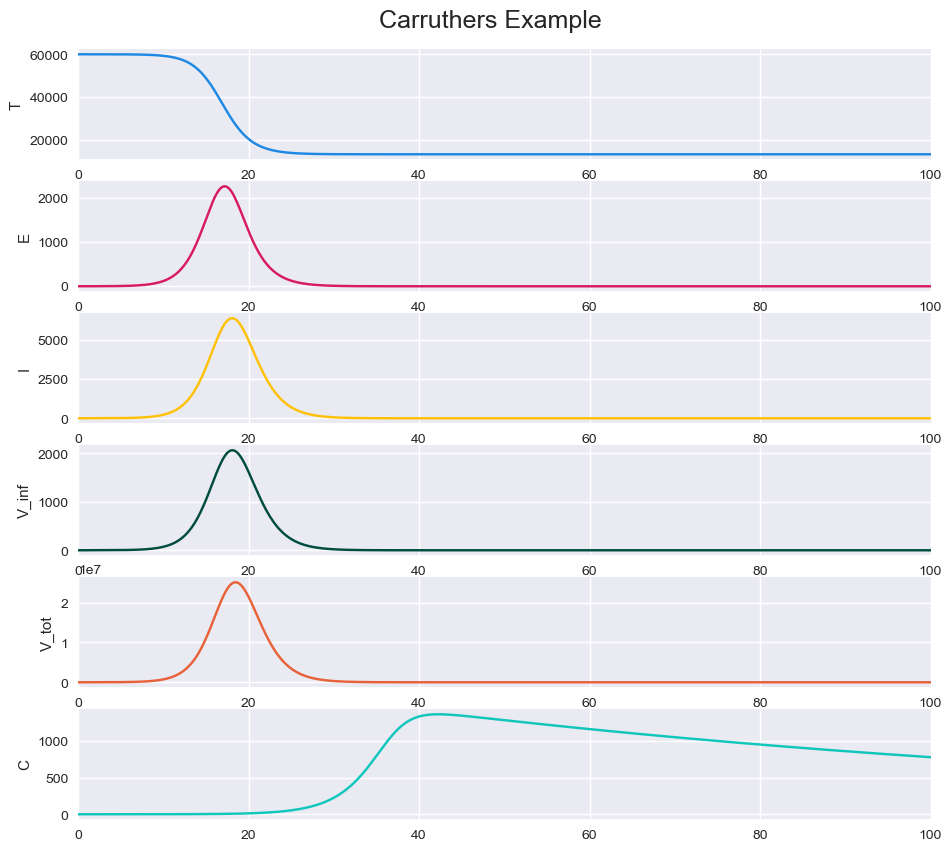

In [53]:
carruthers_result = vn.simulate("config_files/carruthers.txt")
plot_node(carruthers_result, title="Carruthers Example", size=(11,10))

## References:
1. Carruthers, Jonathan, Jingsi Xu, Thomas Finnie, and Ian Hall. "A Within-Host Model of SARS-CoV-2 Infection." MedRxiv (2022): 2022-04.